# Gesture Classification
This notebook was used to train model for senior project about hand gesture EMG wave classification using deep learning.

It was adapted from [Tiny ML on Arduino (Gesture recognition tutorial)](https://github.com/arduino/ArduinoTensorFlowLiteTutorials/tree/master/GestureToEmoji)

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
## Tiny ML on Arduino
### Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

# Graph Data (optional)

We'll graph the input files on two separate graphs. 

plot_six to show six EMG waves side by side.

plot_layer to show three EMG waves on top of each others.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

d_plot={}
d_1={}
d_2={}

GESTURES = [
    "Call",
    "Fist",
    "Rest",
    "Left",
    "Right"
]

SAMPLES_PER_GESTURE = 740
NUM_GESTURES = len(GESTURES)

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]  
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  df = df.dropna()
  
  d_plot[gesture] = df.values.reshape(-1,740,2)

In [3]:
def plot_six(start,gesture='Fist'):
  """
  start: number of the starting sample in the dataset. It will plot starting from that sample and the next 5 samples side by side.
  gesture: name of the gesture wanted to be plot
  """
  pl = d_plot[gesture]

  fig, axes = plt.subplots(2,3, frameon = False)
  plt.rcParams["figure.figsize"] = (16,8)
  fig.subplots_adjust(hspace = .15, wspace=0)

  for ax, d in zip(axes.ravel(), pl[start:start+6]):
    SAMPLES_PER_GESTURE = 740
    sns.lineplot(data = d, linestyle='solid', ax=ax)
    ax.set_ylim([0,pl[start:start+6].max()+20])
    ax.set_xlim([-10,SAMPLES_PER_GESTURE+10])
    ax.get_yaxis().set_visible(False)
    ax.grid(False)


  axes.ravel()[0].get_yaxis().set_visible(True)
  axes.ravel()[3].get_yaxis().set_visible(True)
  fig.suptitle("Acceleration (G)",y=0.92)
  sns.axes_style("whitegrid")

def plot_layer(start,gesture='Fist'):
  """
  start: number of the starting sample in the dataset. It will plot starting from that sample and the next 2 samples layer on each others.
  gesture: name of the gesture wanted to be plot
  """
  pl = d_plot[gesture]
  palette = ['orange','mediumseagreen','deepskyblue']

  plt.rcParams["figure.figsize"] = (20,8)
  for d,p in zip(pl[start:start+3],palette):
    SAMPLES_PER_GESTURE = 740
    sns.lineplot(data = pd.Series(d[:,0]), linestyle='-', color = p)
    sns.lineplot(data = pd.Series(d[:,1]), linestyle='--', color = p)
  plt.ylim([pl[start:start+3].min(),pl[start:start+3].max()+20])
  plt.xlim([0,SAMPLES_PER_GESTURE])
  plt.title('Compare Acceleration (G)')
  sns.axes_style("whitegrid")

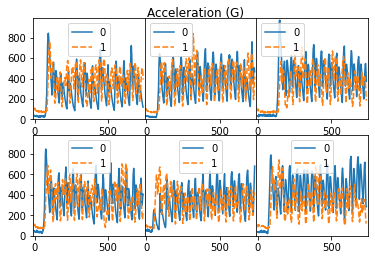

In [4]:
plot_six(10,'Call')

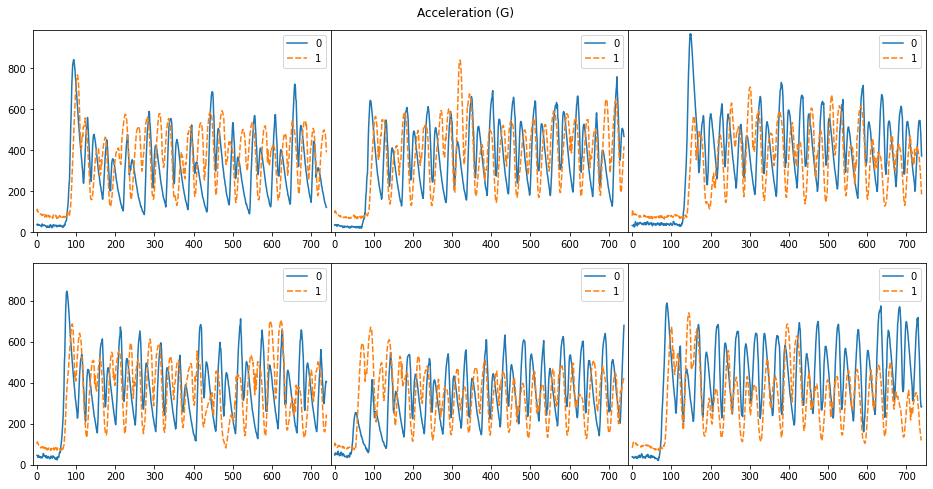

In [5]:
plot_six(10,'Call')

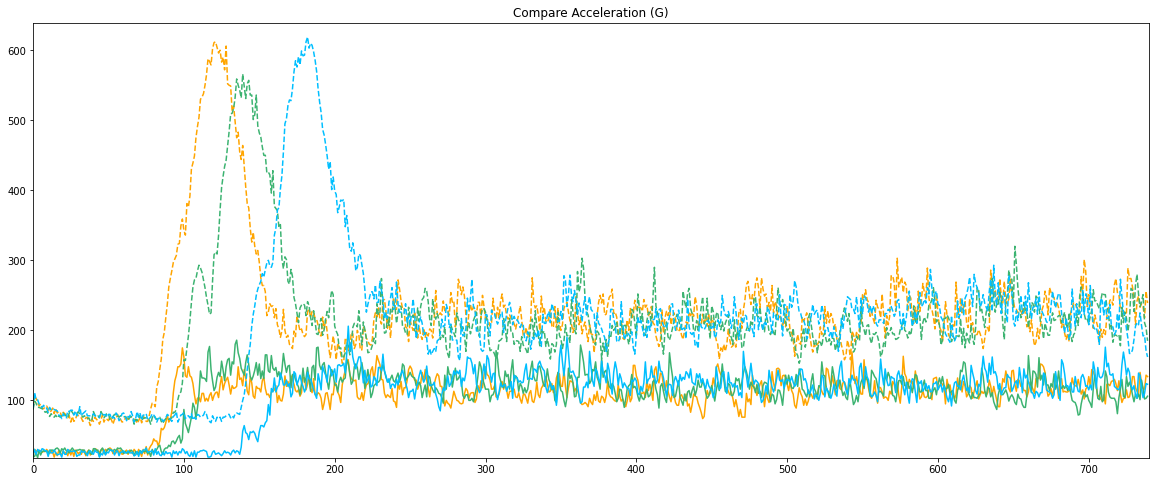

In [6]:
plot_layer(10,'Fist')

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score
from micromlgen import port
from sklearn.svm import SVC

In [8]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for (commented gesture is no longer used)
GESTURES = [
    #"Beak",
    "Call",
    #"Chop",
    "Fist",
    #"Good",
    #"Hi",
    "Rest",
    "Left",
    "Right"
]

SAMPLES_PER_GESTURE = 740

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
data = {}
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv").dropna()

# calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

# normalize the input data, between 0 to 1:
  df = df.values/1000
  data[gesture] = df.reshape(-1,1480)

  for index in range(num_recordings):
    tensor = data[gesture][index]

#add each sample into inputs and outputs list
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.0

Processing index 0 for gesture 'Call'.
	There are 21 recordings of the Call gesture.
Processing index 1 for gesture 'Fist'.
	There are 20 recordings of the Fist gesture.
Processing index 2 for gesture 'Rest'.
	There are 23 recordings of the Rest gesture.
Processing index 3 for gesture 'Left'.
	There are 22 recordings of the Left gesture.
Processing index 4 for gesture 'Right'.
	There are 20 recordings of the Right gesture.
Data set parsing and preparation complete.


In [9]:
print(inputs.shape)
print(outputs.shape)

(106, 1480)
(106, 5)


In [10]:
inputs

array([[0.032, 0.095, 0.032, ..., 0.37 , 0.388, 0.315],
       [0.029, 0.064, 0.03 , ..., 0.465, 0.445, 0.469],
       [0.035, 0.066, 0.031, ..., 0.394, 0.519, 0.375],
       ...,
       [0.029, 0.15 , 0.032, ..., 0.084, 0.15 , 0.075],
       [0.026, 0.1  , 0.028, ..., 0.085, 0.208, 0.082],
       [0.024, 0.1  , 0.024, ..., 0.086, 0.172, 0.083]])

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [11]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [12]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=5)

history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=3, validation_data=(inputs_validate, outputs_validate), callbacks=CALLBACK)

# predict train set for confusion matrix
train_pred = model.predict(inputs_train)
train_pred = train_pred.argmax(axis=1)

Epoch 1/100
21/21 [==============================] - 2s 35ms/step - loss: 0.1511 - accuracy: 0.2698 - val_loss: 0.1339 - val_accuracy: 0.4091
Epoch 2/100
21/21 [==============================] - 0s 8ms/step - loss: 0.1272 - accuracy: 0.3492 - val_loss: 0.1146 - val_accuracy: 0.4545
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1118 - accuracy: 0.3651 - val_loss: 0.0960 - val_accuracy: 0.4545
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1028 - accuracy: 0.4603 - val_loss: 0.0880 - val_accuracy: 0.5000
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.0974 - accuracy: 0.6190 - val_loss: 0.0803 - val_accuracy: 0.7727
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0860 - accuracy: 0.7460 - val_loss: 0.0723 - val_accuracy: 0.7727
Epoch 7/100
21/21 [==============================] - 0s 16ms/step - loss: 0.0805 - accuracy: 0.7937 - val_loss: 0.0651 - val_accuracy: 0.7727
Epoch 8/1

Build [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) from [scikit-learn](https://scikit-learn.org/) to use as a baseline model.

In [13]:
svc = svm.SVC(probability=True, gamma = 0.1)
svc.fit(inputs,outputs.argmax(axis=1))

# train set accuracy
train_pred_svc = svc.predict(inputs)
print(f"train set accuracy: {accuracy_score(outputs.argmax(axis=1), train_pred_svc)*100:.3f} %")

# validation set accuracy
val_pred_svc = svc.predict(inputs_validate)

print(f"Validation set Accuracy: {accuracy_score(outputs_validate.argmax(axis=1),val_pred_svc)*100:.3f} %")

train set accuracy: 96.226 %
Validation set Accuracy: 95.455 %


## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

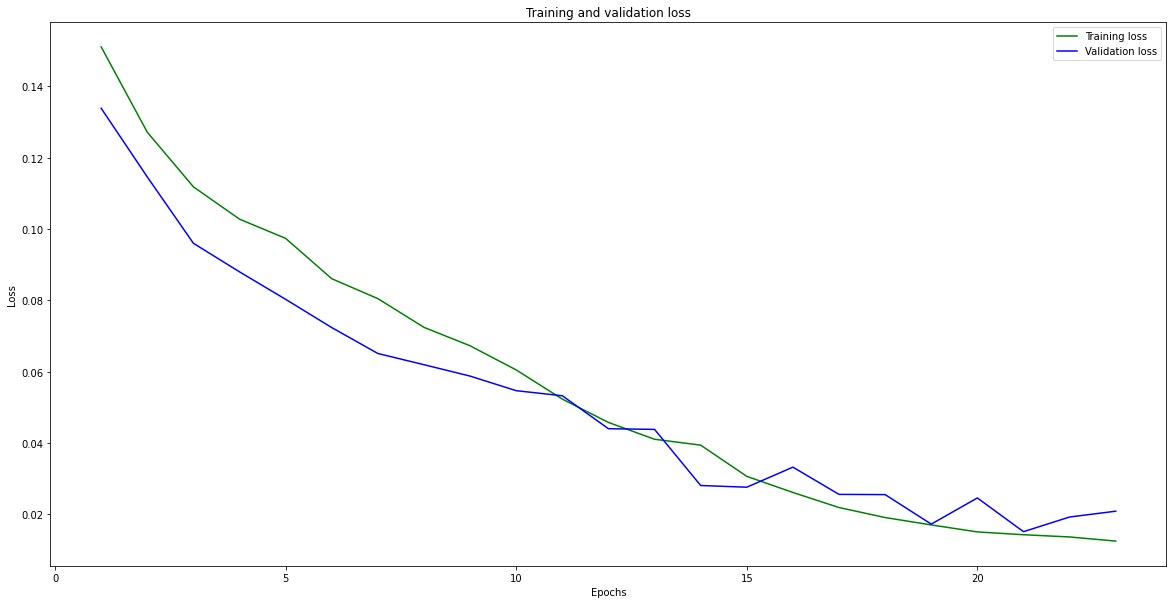

[20.0, 10.0]


In [14]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

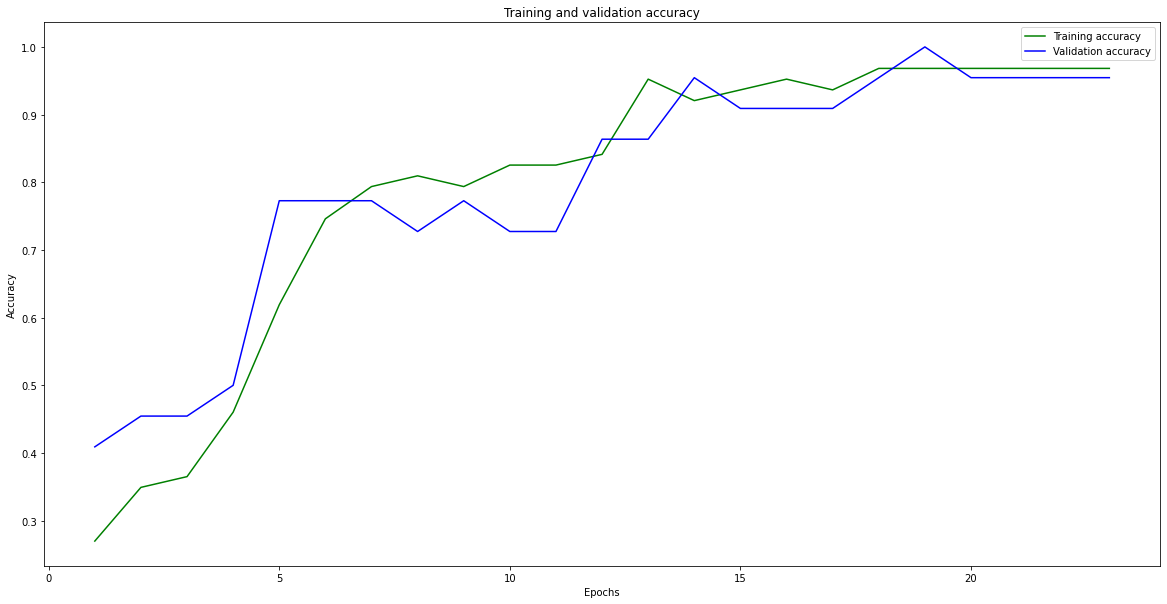

[20.0, 10.0]


In [15]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Run with Test Data
Put our test data into the model


In [16]:
# Plot the confusion matrix on specify dataset
def plot_confusion_matrix(pred = train_pred, label = outputs_train):
  """
  label: true label array
  pred: predicted array
  ex. for both variable - [2 1 1 0 3 2 3 4 3 4 3 4 4 0 0 3 2 2 0 2 3]
  """
  confusion_matrix = tf.math.confusion_matrix(label.argmax(axis=1), pred)
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
  sns.set(font_scale=1)

In [17]:
# use the Neural Network to predict the test inputs
test_pred = model.predict(inputs_test)
test_pred = test_pred.argmax(axis=1)

# print the predictions and the expected ouputs
print("Neural Network\npredictions =", test_pred)
print("actual =", outputs_test.argmax(axis=1))
print(f"Test set Accuracy = {accuracy_score(test_pred, outputs_test.argmax(axis=1))*100:.3f} %")

Neural Network
predictions = [0 1 1 0 3 2 3 4 3 4 3 4 4 0 0 2 2 2 0 2 3]
actual = [2 1 1 0 3 2 3 4 3 4 3 4 4 0 0 3 2 2 0 2 3]
Test set Accuracy = 90.476 %


Neural network train set confusion matrix

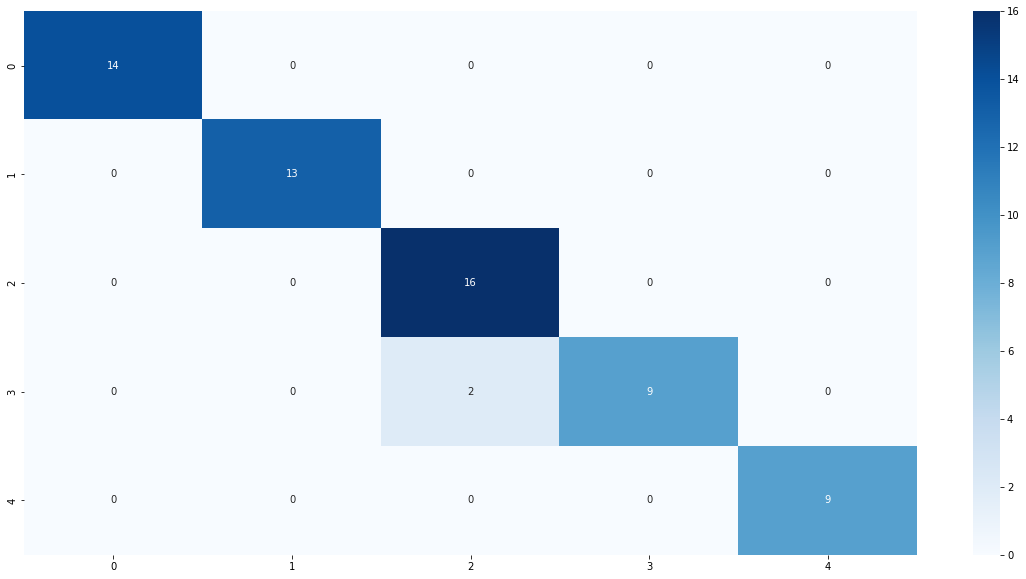

In [18]:
plot_confusion_matrix()

Neural network test set confusion matrix

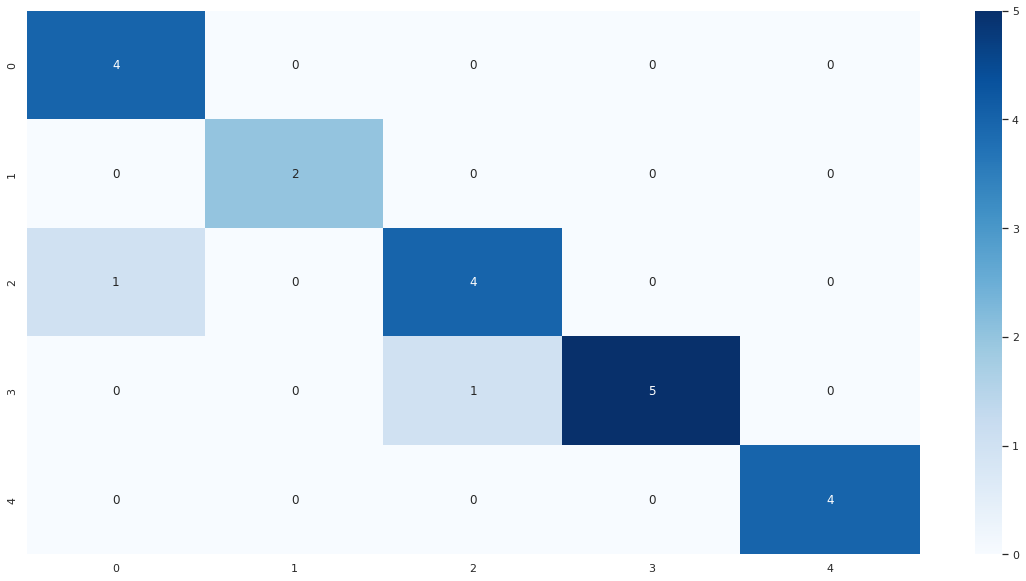

In [19]:
plot_confusion_matrix(test_pred, outputs_test)

In [20]:
# use the SVM to predict the test inputs
test_svc = svc.predict(inputs_test)

# print the predictions and the expected ouputs
print("SVM \npredictions =", test_svc)
print("actual =",outputs_test.argmax(axis=1))
print(f"Test set Accuracy = {accuracy_score(outputs_test.argmax(axis=1),test_svc)*100:.3f} %")

SVM 
predictions = [2 1 1 0 3 2 3 4 3 4 3 4 4 0 0 2 2 2 0 2 3]
actual = [2 1 1 0 3 2 3 4 3 4 3 4 4 0 0 3 2 2 0 2 3]
Test set Accuracy = 95.238 %


SVM train set confusion matrix

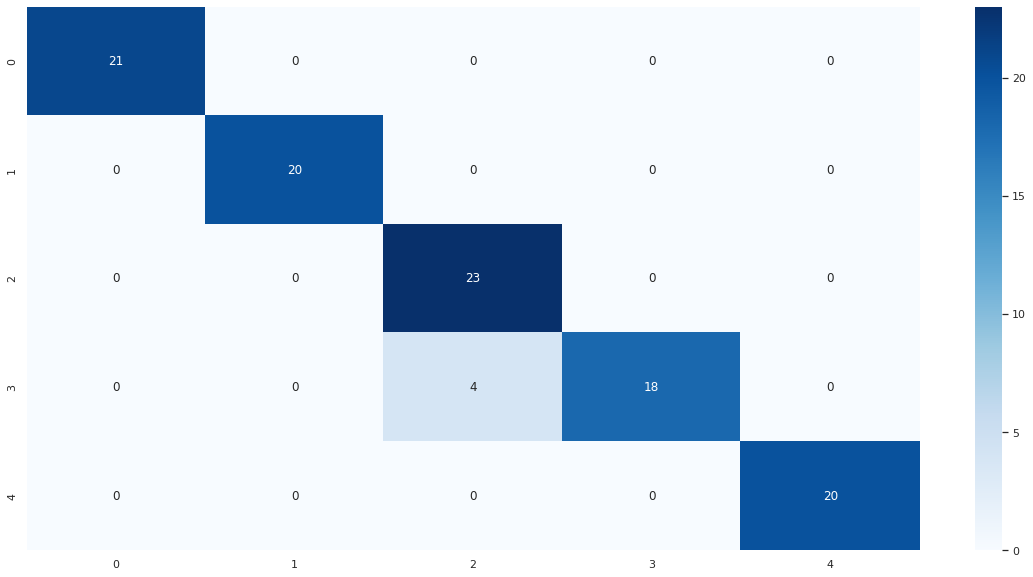

In [21]:
plot_confusion_matrix(train_pred_svc, outputs)

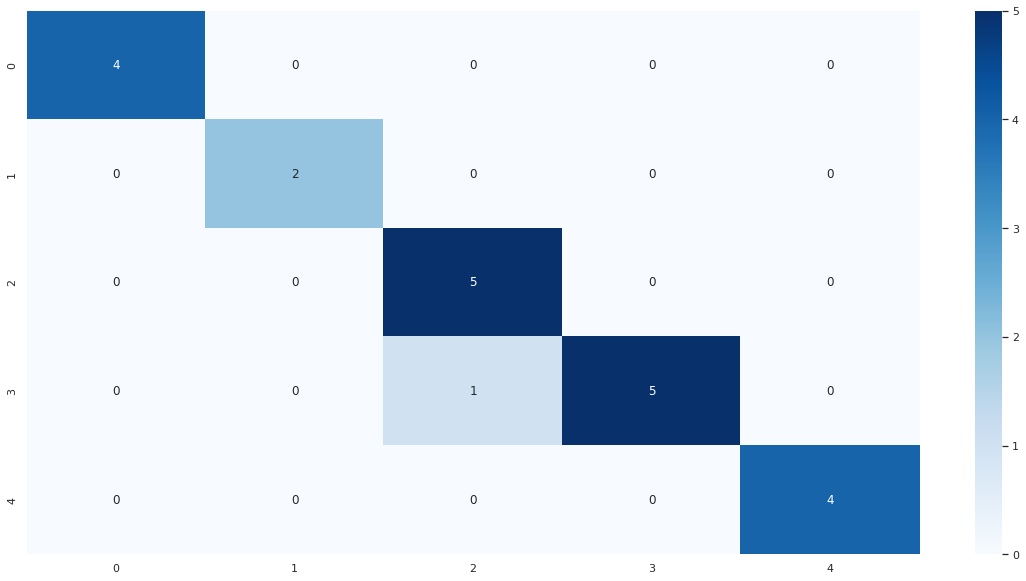

In [22]:
plot_confusion_matrix(test_svc, outputs_test)

In [23]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_motion(i, predictions_array, true_label, data):
  true_label, motion = true_label[i], data[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.plot(range(1,SAMPLES_PER_GESTURE+1), motion.reshape(740,2), linestyle='solid', marker=',')

  predicted_label = predictions_array.argmax()
  if predicted_label == true_label.argmax():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(GESTURES[predicted_label],
                                100*np.max(predictions_array),
                                GESTURES[true_label.argmax()]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label.argmax(axis=1)[i]
  plt.grid(False)
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def show_sample(label = outputs_train, data = inputs_train, num = 6):
  """
  label: true label array
  data: input array
  num: number of sample that want to be plotted
  """
  num_rows = np.ceil(num/2)
  num_cols = 2
  num_images = num_rows*num_cols
  predictions = model.predict(data)
  plt.figure(figsize=(12, 3*num_rows))
  for i in range(num):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_motion(i, predictions[i], label, data)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], label)
  plt.tight_layout()
  plt.show()

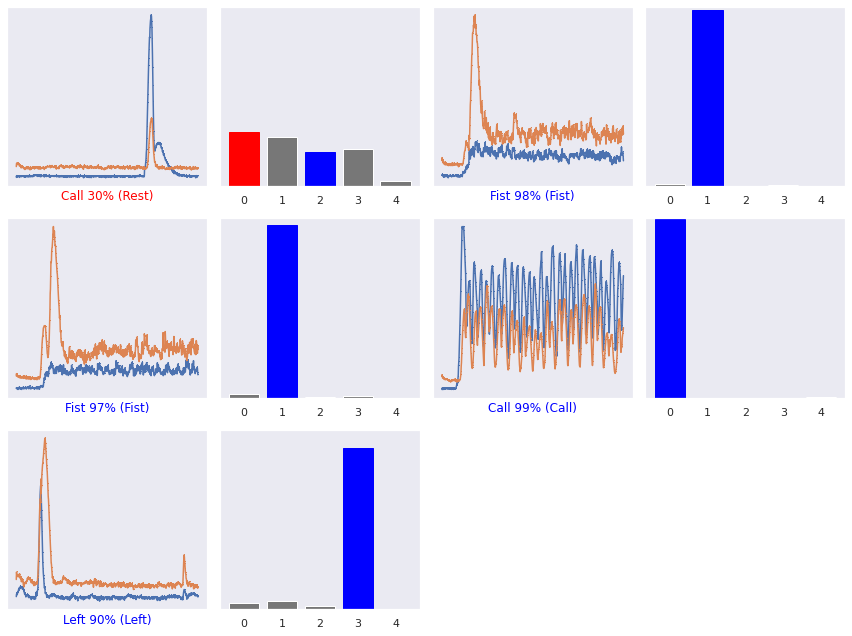

In [24]:
show_sample(outputs_test, inputs_test, 5)

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [25]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpipp_ydx0/assets


Model is 301404 bytes


## Setup Python Environment to export model

The next cell sets up the dependencies in required for the notebook, run it.

In [44]:
!apt-get update
!apt-get -qq install xxd
!pip install micromlgen

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [45]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,858,692 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [51]:
classmap = {
    0: "Call",
    1: "Fist",
    2: "Rest",
    3: "Left",
    4: "Right"
}

with open('svc.h', 'w') as file:
  file.write(port(svc, classmap=classmap))    